In [1]:
# 필요 라이브러리 로드
from tqdm import tqdm

In [2]:
# 필요 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("행정동_월별_배출량.csv",encoding = "cp949")

In [4]:
df

,y_m,emd_nm,em_g
0,2018-01,남원읍,42437700.0
1,2018-01,대륜동,57612600.0
2,2018-01,대정읍,38885550.0
3,2018-01,대천동,53858550.0
4,2018-01,동홍동,118701000.0
...,...,...,...
1671,2021-02,알수없음,1985100.0
1672,2021-03,알수없음,2153800.0
1673,2021-04,알수없음,1936900.0
1674,2021-05,알수없음,1910750.0


### 날짜 지정 범위 생성과 시리즈 객체 변환

In [5]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
    # 행정동별로 데이터를 뽑습니다.
    location = df[df['emd_nm']==i]
    ## 날짜 지정 범위는 시작 월부터 2021년 7월 전까지 기준
    index = pd.date_range(min(location['y_m']),'2021-07',freq='BM') 
    ## 시리즈 객체로 변환
    ts = pd.Series(location['em_g'].values,index=index)
    return ts

### 변동 계수
배출량 변동 계수가 높은 행정동을 로그 정규화 시 예측 성능이 저하된다.
따라서 변동 계수가 0.3 이하의 데이터 값만 로그 정규화하여 사용

In [6]:
# 배출량 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['emd_nm']).em_g.std()/df.groupby(['emd_nm']).em_g.mean()
    cv = cv_data[i]
    return cv

### 행정동별 특성
#### 계절성이 있는 행정동

adf - test는 통계학에서 실행하는 가설 검정의 절차를 따른다.
- 귀무가설:시계열 자료가 정상 시계열이 아니다.
- 대립 가설: 시계열 자료가 정상성을 만족한다.

pmdarima 패키지에 있는 ADFTest클래스 import

p-value 0.05보다 낮으면 대립가설이 채택 -> 정상시계열이다. -> 차분이 필요하지 않다.

0.05보다 높으면 귀무가설이 채택 -> 정상시계열이 아니다 -> 차분이 필요하다.

In [7]:
new_df = df

100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 304.35it/s]


<AxesSubplot:>

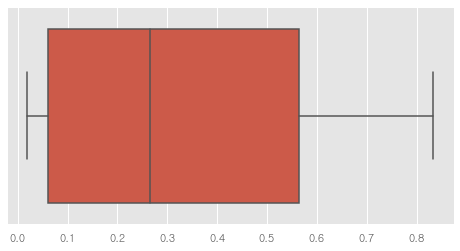

In [8]:
from pmdarima.arima import ADFTest
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = []
count = 0
skipped = []

for i in tqdm(new_df['emd_nm'].unique()):
    ts = time_series(new_df,i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)

plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [9]:
# p-value가 0.05보다 작은 행정동의 개수
print(count)

9


In [10]:
# ADF-Test 오류 행정동 개수
if skipped:
    print(f"WarningCount: {len(skipped)}, emd_nm_list:{skipped}")

42개의 행정동중 9개를 제외한 33개의 행정동이 정상시계열이 아니다.

## 모델 구축과 검증
### 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [11]:
#!pip install tzlocal

In [12]:
# import rpy2
# from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

# utils = importr('utils') # utils 패키지를 임포트
# utils.install_packages('forecast') # r의 forecast 패키지 설치.
# utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

### 시계열 모델 선택과 검증
#### 1. 자기회귀누적이동평균(ARIMA) 모델

In [13]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=2) # 이후 2개월(h=2)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # em_g 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

loc_name = []
final_pred1 = []
final_pred2 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    
    cv = coefficient_variation(new_df, i)
    # 배출량 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 자동회귀누적이동평균 model
        forecast_log = auto_arima(train_log)
        # 2개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
    # 배출량 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 자동회귀누적이동평균 model
        forecast = auto_arima(train)
        # 2개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])
    

100%|██████████████████████████████████████████| 42/42 [00:14<00:00,  2.86it/s]


In [14]:
# 7월 예상
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
남원읍,6.292705e+07
대륜동,4.674674e+07
대정읍,1.127091e+08
대천동,5.691631e+07
동홍동,8.776890e+07
서홍동,3.067016e+07
성산읍,8.568876e+07
송산동,3.083344e+07
안덕면,5.004729e+07
영천동,3.507470e+07


In [15]:
# 8월 예상
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
남원읍,6.292705e+07
대륜동,4.756361e+07
대정읍,1.144966e+08
대천동,6.020141e+07
동홍동,9.275622e+07
서홍동,3.528438e+07
성산읍,8.568876e+07
송산동,2.805486e+07
안덕면,5.634425e+07
영천동,3.507470e+07


In [16]:
# 로그정규화와 ARIMA를 활용한 최종 7,8월 행정동별 결과 예상 데이터
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-07","0_y" : "2021-08"},inplace=True)
final

,행정동명,2021-07,2021-08
0,남원읍,6.292705e+07,6.292705e+07
1,대륜동,4.674674e+07,4.756361e+07
2,대정읍,1.127091e+08,1.144966e+08
3,대천동,5.691631e+07,6.020141e+07
4,동홍동,8.776890e+07,9.275622e+07
5,서홍동,3.067016e+07,3.528438e+07
6,성산읍,8.568876e+07,8.568876e+07
7,송산동,3.083344e+07,2.805486e+07
8,안덕면,5.004729e+07,5.634425e+07
9,영천동,3.507470e+07,3.507470e+07


In [17]:
final.to_csv("final_1_20210708_log.csv",encoding = "cp949",index=False)

#### 2. 지수평활법

In [18]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=2) # 이후 2개월(h=2)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets 
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

loc_name = []
final_pred1 = []
final_pred2 = []


   
    
    
for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    
    cv = coefficient_variation(new_df, i)
    # 배출량 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 지수평활 model
        forecast_log = ets(train_log)
        # 2개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
    # 배출량 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 지수평활 model
        forecast = ets(train)
        # 2개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])

100%|██████████████████████████████████████████| 42/42 [00:20<00:00,  2.08it/s]


In [19]:
#7월 예상 데이터
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
남원읍,6.292673e+07
대륜동,4.674584e+07
대정읍,1.131597e+08
대천동,5.617861e+07
동홍동,8.652512e+07
서홍동,2.976835e+07
성산읍,8.235627e+07
송산동,3.124332e+07
안덕면,4.643683e+07
영천동,3.495037e+07


In [20]:
#7월 예측 데이터
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
남원읍,6.292673e+07
대륜동,4.674584e+07
대정읍,1.152269e+08
대천동,5.617861e+07
동홍동,8.652512e+07
서홍동,2.976835e+07
성산읍,8.235627e+07
송산동,3.124332e+07
안덕면,4.643683e+07
영천동,3.495037e+07


In [21]:
# 로그정규화와 지수평활법을 활용한 최종 7,8월 예측 데이터
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-07","0_y" : "2021-08"},inplace=True)
final

,행정동명,2021-07,2021-08
0,남원읍,6.292673e+07,6.292673e+07
1,대륜동,4.674584e+07,4.674584e+07
2,대정읍,1.131597e+08,1.152269e+08
3,대천동,5.617861e+07,5.617861e+07
4,동홍동,8.652512e+07,8.652512e+07
5,서홍동,2.976835e+07,2.976835e+07
6,성산읍,8.235627e+07,8.235627e+07
7,송산동,3.124332e+07,3.124332e+07
8,안덕면,4.643683e+07,4.643683e+07
9,영천동,3.495037e+07,3.495037e+07


In [22]:
final.to_csv("final_2_20210708_log.csv",encoding = "cp949",index=False)

#### 3. log 정규화와 앙상블을 적용

In [23]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# pandas2ri를 활성화 
pandas2ri.activate()

hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(ts)
        hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm
                        a.arg=list(max.p=2, d=d_params), # auto_arima parameter
                        weight="equal") # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=2) # 이후 2개월(h=2)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('em_g')
        outdf
    }
""" 
# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

loc_name = []
final_pred1 = []
final_pred2 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    cv = coefficient_variation(new_df, i)
    # 배출량 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 앙상블 예측
        forecast_log = hybridModel(train_log)
        #2개월 예상, final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
    # 배출량 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 앙상블 예측
        forecast = hybridModel(train)
        # 2개월 예상, final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])


100%|██████████████████████████████████████████| 42/42 [00:34<00:00,  1.23it/s]


In [24]:
#7월 예측값
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
남원읍,6.553753e+07
대륜동,4.867065e+07
대정읍,1.118872e+08
대천동,5.988741e+07
동홍동,9.269669e+07
서홍동,3.247225e+07
성산읍,8.263498e+07
송산동,3.166434e+07
안덕면,4.765261e+07
영천동,3.704528e+07


In [25]:
#8월 예측값
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
남원읍,6.597585e+07
대륜동,4.863175e+07
대정읍,1.148493e+08
대천동,6.185071e+07
동홍동,9.360114e+07
서홍동,3.521794e+07
성산읍,8.505648e+07
송산동,3.007122e+07
안덕면,5.081169e+07
영천동,3.897108e+07


In [26]:
# 로그 정규화와 앙상블을 활용한 최종 7,8월 예측 데이터 프레임 생성 
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-07","0_y" : "2021-08"},inplace=True)
final

,행정동명,2021-07,2021-08
0,남원읍,6.553753e+07,6.597585e+07
1,대륜동,4.867065e+07,4.863175e+07
2,대정읍,1.118872e+08,1.148493e+08
3,대천동,5.988741e+07,6.185071e+07
4,동홍동,9.269669e+07,9.360114e+07
5,서홍동,3.247225e+07,3.521794e+07
6,성산읍,8.263498e+07,8.505648e+07
7,송산동,3.166434e+07,3.007122e+07
8,안덕면,4.765261e+07,5.081169e+07
9,영천동,3.704528e+07,3.897108e+07


In [27]:
final.to_csv("final_3_20210708_hybrid.csv",encoding = "cp949",index=False)

## 예측 결과 제출 파일 생성
### 로그 정규화를 활용한 ARIMA 활용하여 예측
- 평가 지표를 분석하여 2개월치 예측 성능이 가장 좋은 로그 정규화를 활용한 ARIMA 이용

In [28]:
# 결과를 삽입할 데이터 프레임 로드
sub = pd.read_csv("submission.csv",encoding = "cp949")
sub.head()

,NO,행정동명,7월 배출량(g),8월 배출량(g)
0,1,한림읍,NaN,NaN
1,2,애월읍,NaN,NaN
2,3,구좌읍,NaN,NaN
3,4,조천읍,NaN,NaN
4,5,한경면,NaN,NaN


In [29]:
# 로그 정규화를 활용한 ARIMA 결과치 로드
pred = pd.read_csv("final_1_20210708_log.csv",encoding = "cp949")
pred.head()

,행정동명,2021-07,2021-08
0,남원읍,6.292705e+07,6.292705e+07
1,대륜동,4.674674e+07,4.756361e+07
2,대정읍,1.127091e+08,1.144966e+08
3,대천동,5.691631e+07,6.020141e+07
4,동홍동,8.776890e+07,9.275622e+07


In [30]:
# 두 데이터 프레임 결합
sub = pd.merge(sub,pred,how = "left", on = "행정동명")
sub.head()

,NO,행정동명,7월 배출량(g),8월 배출량(g),2021-07,2021-08
0,1,한림읍,NaN,NaN,8.698212e+07,9.121725e+07
1,2,애월읍,NaN,NaN,1.060982e+08,1.084399e+08
2,3,구좌읍,NaN,NaN,3.965382e+07,4.150050e+07
3,4,조천읍,NaN,NaN,6.392775e+07,6.392775e+07
4,5,한경면,NaN,NaN,2.843817e+07,2.981619e+07


In [31]:
#소수점 첫째자리까지 제시
sub = sub.drop(["7월 배출량(g)","8월 배출량(g)"],axis=1)
sub.rename(columns = {"2021-07" : "7월 배출량(g)","2021-08" : "8월 배출량(g)"},inplace=True)
sub["7월 배출량(g)"] = sub["7월 배출량(g)"].apply(lambda x : round(x,1))
sub["8월 배출량(g)"] = sub["8월 배출량(g)"].apply(lambda x : round(x,1))
sub

,NO,행정동명,7월 배출량(g),8월 배출량(g)
0,1,한림읍,86982118.4,91217246.8
1,2,애월읍,106098161.0,108439922.0
2,3,구좌읍,39653823.7,41500497.4
3,4,조천읍,63927750.0,63927750.0
4,5,한경면,28438171.1,29816192.1
5,6,일도1동,11036515.0,21220392.8
6,7,일도2동,175708254.5,172483638.6
7,8,이도1동,31397303.2,30035789.2
8,9,이도2동,255695888.2,248269083.6
9,10,삼도1동,69742982.6,67720570.1


In [32]:
sub.to_csv("7_8월_배출량_예측결과.csv",encoding = "cp949", index = False)